SVD Model : Test Set
RMSE: 2.8411
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Item-based Model : Test Set
RMSE: 2.9992
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
User-based Model : Test Set
RMSE: 2.9848


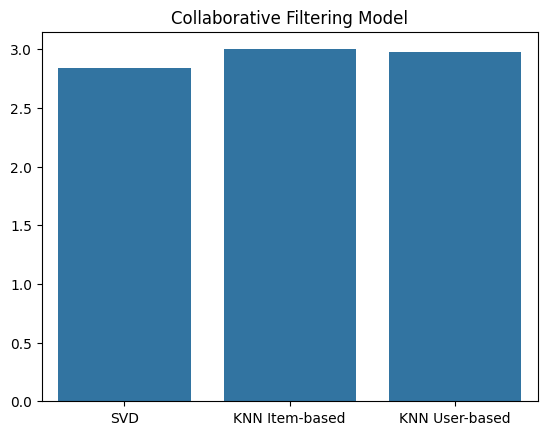

SVD Model
Average Prediction score : 7.788252030437108
Average Actual score : 7.663
KNN Item-based Model
Average Prediction score : 7.805046937875788
Average Actual score : 7.804
KNN User-based Model
Average Prediction score : 7.769090869285327
Average Actual score : 7.804
Amazon Customer ['Oppo F1S (Grey, 32GB)', 'Honor 6X (Gold, 32GB)', 'Motorola Moto Z Play - Black - 32GB (U.S. Warranty)', 'Lenovo S850 (White, 16GB)', 'Lenovo Vibe P1 Turbo (Grey)']
mike ['LG Electronics KM900 Arena Smartphone (Dolby Mobile Surround, FM Transmitter, GPS, 5MP,WLAN ) silber']
unknown ['Alcatel OneTouch 708', 'Nokia 5310 XpressMusic', 'Samsung Galaxy Y Duos GT-S6102', 'Samsung GT-S6310DBNITV Galaxy Young, Blu [Italia]', 'Sony Xperia L']
Cliente Amazon ['Samsung Galaxy J5 - Smartphone libre Android (pantalla 5", cÃ¡mara 13 Mp, 8 GB, Quad-Core 1.2 GHz, 1.5 GB RAM), blanco', 'Huawei P9 Smartphone, LTE, Display 5.2" FHD, Memoria Interna 32 GB, 3 GB RAM, Processore Kirin 955, Fotocamera 12 MP, Argento [Versi

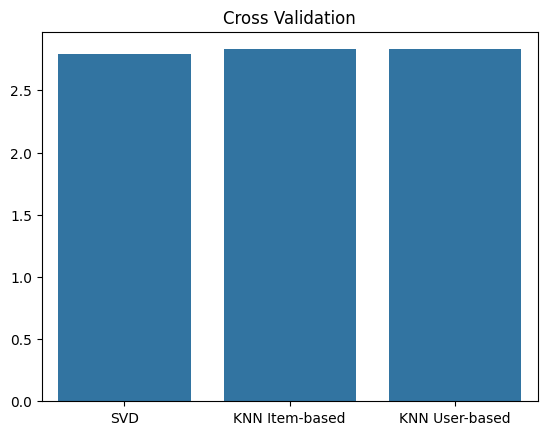

In [ ]:
#For numerical operations
import pandas as pd

# For loading the excel data
import numpy as np

# seaborn and matplotlib  packages are  used for visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For SVD and KNN model prediction
from surprise import SVD, Dataset, Reader
from surprise import accuracy
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise.model_selection import cross_validate


#reading CSV file

review_df1=pd.read_csv(r'/content/phone_user_review_file_1.csv',encoding='latin-1')
review_df2=pd.read_csv(r'/content/phone_user_review_file_2.csv',encoding='latin-1')
review_df3=pd.read_csv(r'/content/phone_user_review_file_3.csv',encoding='latin-1')
review_df4=pd.read_csv(r'/content/phone_user_review_file_4.csv',encoding='latin-1')
review_df5=pd.read_csv(r'/content/phone_user_review_file_5.csv',encoding='latin-1')
review_df6=pd.read_csv(r'/content/phone_user_review_file_6.csv',encoding='latin-1')

#concatenating all dataframes
review_df=pd.concat([review_df1,review_df2,review_df3,review_df4,review_df5,review_df6])

#rounded off score column
review_df['score']=review_df['score'].round(0)

#checking for null values
review_df.isnull().sum()

#replacing null values with median
review_df['score']=review_df['score'].fillna(review_df['score'].median())
review_df['score_max']=review_df['score_max'].fillna(review_df['score_max'].median())

#replacing null values for categorical columns
review_df['extract']=review_df['extract'].fillna('unknown')
review_df['author']=review_df['author'].fillna('unknown')

#dropping duplicates
review_df.duplicated().sum()
review_df=review_df.drop_duplicates()

#keep only 1 million samples
sample_review_df=review_df.sample(n=1000000, random_state=612)

#dropping unwanted columns and keep author, product & score columns
user_review_df=sample_review_df[['author','product','score']]

# Top 10 most rated products
user_review_df.groupby('product')['score'].count().sort_values(ascending=False).head(10)

# Top 10 users with most number of reviews
user_review_df['author'].value_counts().sort_values(ascending=False).head(10)

# Products having more than 50 ratings
products_50_df=user_review_df['product'].value_counts()
products_50_list=products_50_df[products_50_df>50].index

# Users who has given more than 30 reviews
users_50_df=user_review_df['author'].value_counts()
users_50_list=users_50_df[users_50_df>50].index

rating50_df=user_review_df[(user_review_df['product'].isin(products_50_list)) & (user_review_df['author'].isin(users_50_list))]

#Popularity based model and top 5 mobile phones
popularity_model_df = pd.DataFrame(user_review_df.groupby('product')['score'].mean())
popularity_model_df['review_count']=pd.DataFrame(user_review_df.groupby('product')['score'].count())
popularity_model_df.sort_values(by=['score', 'review_count'], ascending=False).head()

# Keep only 5000 data samples on final_df dataset. Use random state=612
final_df = rating50_df.sample(n=5000, random_state=612)

#Collaborative filtering model using SVD
reader=Reader(rating_scale=(1,10))
data=Dataset.load_from_df(final_df, reader)

#splitting train and test data
trainset, testset = train_test_split(data, test_size=0.2, random_state=612)

#Fit and predict using SVD
svd_model = SVD(random_state=612)
svd_model.fit(trainset)

svd_model_pred = svd_model.test(testset)
print("SVD Model : Test Set")
svd_rmse=round(accuracy.rmse(svd_model_pred),2)

#kNNWithMeans
sample_data = final_df.sample(n=5000, random_state=612)
reader=Reader(rating_scale=(1,10))
data=Dataset.load_from_df(sample_data, reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=612)

#Fit and predict using kNNWithMeans_Item based
knn_item_model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_item_model.fit(trainset)

knn_item_model_pred = knn_item_model.test(testset)

print("Item-based Model : Test Set")
knn_item_rmse=round(accuracy.rmse(knn_item_model_pred),2)

#Fit and predict using kNNWithMeans_User based
knn_user_model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
knn_user_model.fit(trainset)

knn_user_model_pred = knn_user_model.test(testset)

print("User-based Model : Test Set")
knn_user_rmse=round(accuracy.rmse(knn_user_model_pred),2)

plt.title('Collaborative Filtering Model')
sns.barplot(x=['SVD','KNN Item-based', 'KNN User-based'],y=[svd_rmse,knn_item_rmse,knn_user_rmse])
plt.show()

print('SVD Model')
svd_model_pred_df=pd.DataFrame(svd_model_pred)
print('Average Prediction score :', svd_model_pred_df['est'].mean())
print('Average Actual score :', svd_model_pred_df['r_ui'].mean())

print('KNN Item-based Model')
knn_item_model_pred_df=pd.DataFrame(knn_item_model_pred)
print('Average Prediction score :', knn_item_model_pred_df['est'].mean())
print('Average Actual score :', knn_item_model_pred_df['r_ui'].mean())

print('KNN User-based Model')
knn_user_model_pred_df=pd.DataFrame(knn_user_model_pred)
print('Average Prediction score :', knn_user_model_pred_df['est'].mean())
print('Average Actual score :', knn_user_model_pred_df['r_ui'].mean())

#Function to get top 5 predictions
def get_top_5(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_5 = get_top_5(knn_item_model_pred, n=5)
for uid, user_ratings in top_5.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("Cross-validation results")

print('SVD Model')
cross_val_svd = cross_validate(svd_model, data, measures=['RMSE'], cv=5, verbose=True)
print(cross_val_svd)

print('KNN Item Model')
cross_val_knn_item = cross_validate(svd_model, data, measures=['RMSE'], cv=5, verbose=True)
print(cross_val_knn_item)

print('KNN User Model')
cross_val_knn_user = cross_validate(svd_model, data, measures=['RMSE'], cv=5, verbose=True)
print(cross_val_knn_user)

plt.title('Cross Validation')
sns.barplot(x=['SVD','KNN Item-based', 'KNN User-based'],y=[round(cross_val_svd['test_rmse'].mean(),2),round(cross_val_knn_item['test_rmse'].mean(),2),round(cross_val_knn_item['test_rmse'].mean(),2)])
plt.show()